# Исследование ошибки в моделях категоризации

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

### Предобработка данных

Загрузим исходные данные и проведём первичную обработку

In [12]:
path = "dataset1.csv"

df = pd.read_csv(path)
#Проверим датасет, на наличие пустых строк
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  150000 non-null  int64  
 1   0           150000 non-null  float64
 2   1           150000 non-null  float64
 3   2           150000 non-null  float64
 4   3           150000 non-null  float64
 5   4           150000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 6.9 MB
None


Пустые строки не обнаружены, датасет целый

In [4]:
data = df.to_numpy()[:,1:]

Посмотрим, имеются ли взаимозависимые столбцы, посчитаем коэффициенты корреляции между каждым столбцом

Корреляционная матрица:
[[ 1.         -0.20761613 -0.41716668 -0.11088836 -0.11884871]
 [-0.20761613  1.          0.26621865 -0.14664717  0.13109507]
 [-0.41716668  0.26621865  1.          0.26002505 -0.08388506]
 [-0.11088836 -0.14664717  0.26002505  1.         -0.10942455]
 [-0.11884871  0.13109507 -0.08388506 -0.10942455  1.        ]]
---------------------------------------------------------------
Визуализация:


<Axes: >

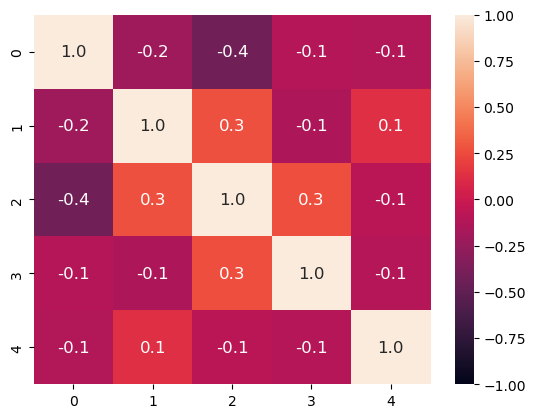

In [5]:
corr_matrix = np.corrcoef(data, rowvar=False)
#выведем матрицу
print('Корреляционная матрица:')
print(corr_matrix)
print('-'*63)
#визуализируем матрицу
print('Визуализация:')
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".1f", annot_kws={"size": 12})

Можем заметить, что для пар признаков (0,2) и (1,2) наблюдается слабая корреляция. Для остальных признаков корреляция практически отсутствует.

Для выявления аномалий в данных проанализируем распределения каждого из признаков.

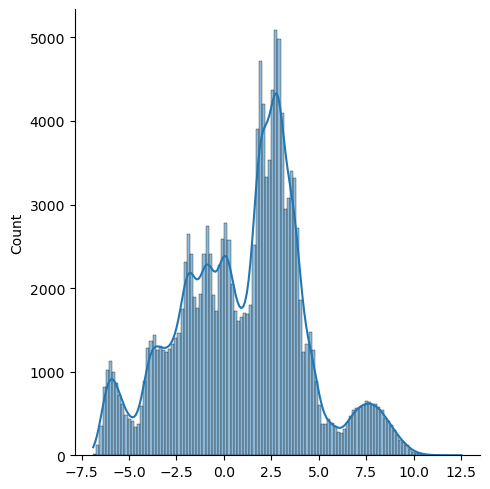

In [11]:
#Первый признак
sns.displot(data[:,0], kde=True)

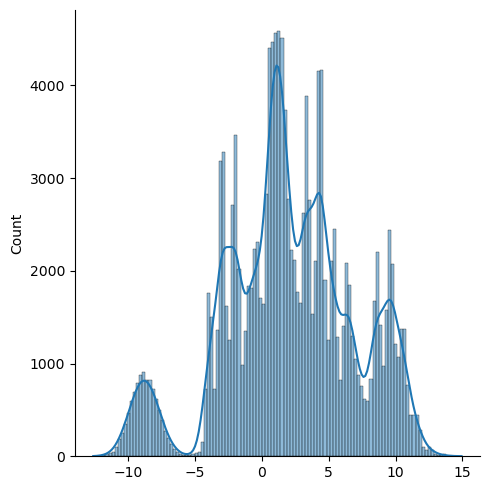

In [12]:
#Второй признак
sns.displot(data[:,1], kde=True)

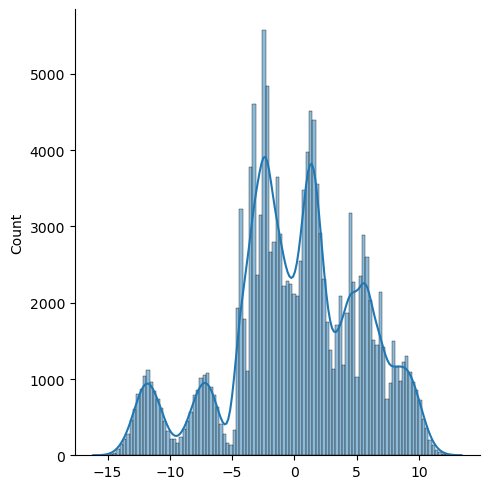

In [13]:
#Третий признак
sns.displot(data[:,2], kde=True)

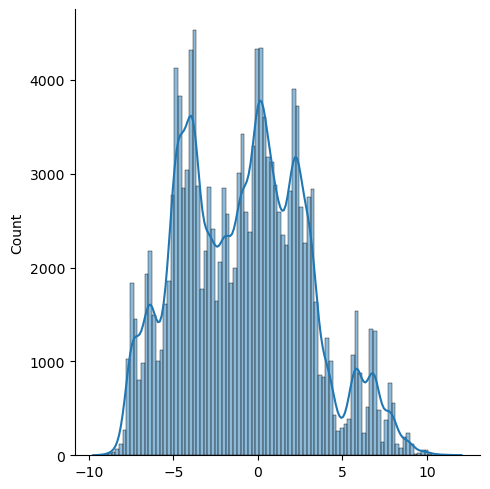

In [14]:
#Четвёртый признак
sns.displot(data[:,3], kde=True)

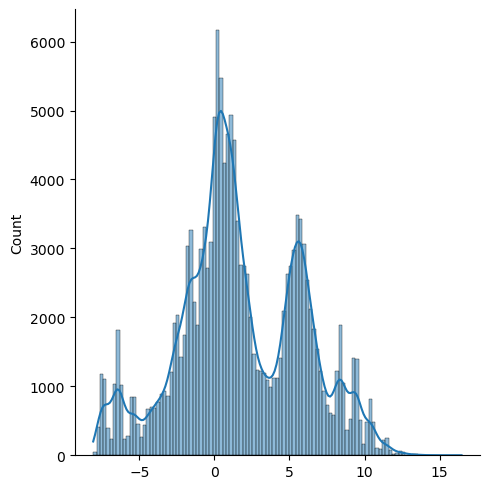

In [15]:
#Пятый признак
sns.displot(data[:,4], kde=True)

Можно видеть, что распределение признаков имеет сложный вид, который можно представить суммой нормальных распределений. 

Отсюда же видно, почему у некоторых признаков имеется слабая корреляция: центры некоторых гауссианов достаточно близки друг к другу.

Распределения получились несимметричными. Для каждого из признаков выбросы не наблюдаются

### Метод ближайшего соседа

Реализуем кластеризацию данным методом. Реализация находится в ```clustering.py```

Суть кластеризации основана на том, что постепенно объединяются в кластеры ближайшие пары элементов. Затем процесс повторяется для первых кластеров и так далее. Своего рода получается структура двоичного дерева. 

Дерево будем строить следующим образом. В листьях дерева будут находиться индексы элементов из датасета, а во всех остальных узлах будем хранить расстояние от кластеров, которые имеют общий корень

Попробуем применить кластеризацию на части датасета, так как полностью он слишком большой и кластеризация займёт много времени

In [9]:
import clustering

In [13]:
root = clustering.single_linkage(data[:10])

В файле ```clustering.py``` есть метод, позволяющий отрисовать бинарное дерево, вот его пример в виде готовой картинки:

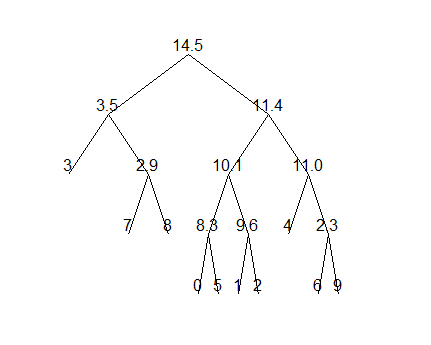

Для отрисовки использовался код

```
turtle.speed(0)
turtle.hideturtle()
draw_tree(root, 0, 300, 80)
turtle.done()
```

Реализация отрисовки такого дерева взята с открытых источников

Как можно видеть, примерно различимую структуру можно нарисовать всего только для порядка десяти сэмплов.

Строить весь датасет будет непрактично по трём причинам:

1. Долгий процесс кластеризации
2. Долгий процесс отрисовки
3. Дерево будет выглядить очень плохо из-за того, что чем ниже оно идёт, тем меньше визуальное расстояние между ними, все вершины будут накладываться


### Метод дальнейшего соседа

Метод аналогичен ближайшему, только мы заменяем критерий минимального расстояния между кластерами на максимальный

Посмотрим на пример кластеризации для тех же десяти сэмплов

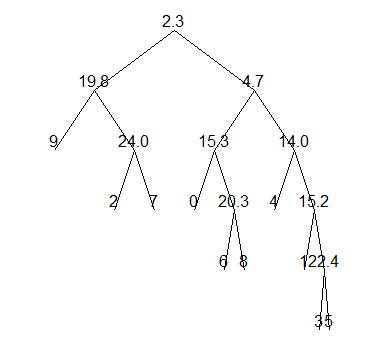

Структура явно изменилась